In [ ]:
# Quantum Error Correction Using 3 repetition Codes under Random X, Z Errors


## Shor’s 9-qubit code overview

1. **Phase-flip protection (outer 3-qubit code):**

   Encode each logical basis state as
   $
   |0_L\rangle = \frac{1}{\sqrt{2}}\big(|000\rangle + |111\rangle\big),\quad
   |1_L\rangle = \frac{1}{\sqrt{2}}\big(|000\rangle - |111\rangle\big).
   $
   These are eigenstates of (X_1X_2) and (X_2X_3) with eigenvalue (+1).

2. **Bit-flip protection (inner 3-qubit code):**

   Apply the **bit-flip repetition** to each of the three qubits above, replacing
   (|0\rangle \mapsto |000\rangle,\ |1\rangle \mapsto |111\rangle.)

Hence the full **9-qubit codewords** are:
$
|0_L\rangle = \frac{1}{2\sqrt{2}}\big(|000\rangle+|111\rangle\big)^{\otimes 3},\quad
|1_L\rangle = \frac{1}{2\sqrt{2}}\big(|000\rangle-|111\rangle\big)^{\otimes 3}.
$

## Error analysis

Suppose an arbitrary Pauli error acts:
$
E = X_1^{e_1}\cdots X_9^{e_9} Z_1^{f_1}\cdots Z_9^{f_9},\quad e_i,f_i\in{0,1}.
$

* The **Z-type stabilizers** detect bit-flip errors (since (Z_iZ_j) anticommutes with (X) errors).
* The **X-type stabilizers** detect phase-flip errors (since (X_iX_j\cdots) anticommutes with (Z) errors).

For any valid encoded state (|\psi_L\rangle),
$
E|\psi_L\rangle = \alpha |e_1e_2\ldots e_9\rangle + \beta |\bar{e}_1\bar{e}_2\ldots \bar{e}_9\rangle,
\quad \bar{e}_i = e_i \oplus 1,
$
and the stabilizer eigenvalues depend **only** on the error pattern ((e_i,f_i)), not on $\alpha,\beta$.

Thus, just as the 3-repetition code’s (Z_1Z_2, Z_2Z_3) syndromes detect bit-flip parity,
the 9-qubit Shor code’s 8 stabilizers together reveal which qubit (if any) experienced an X or Z error — while preserving the logical information in $\alpha,\beta$.




In [1]:
## Step1: Logical zero state preparation

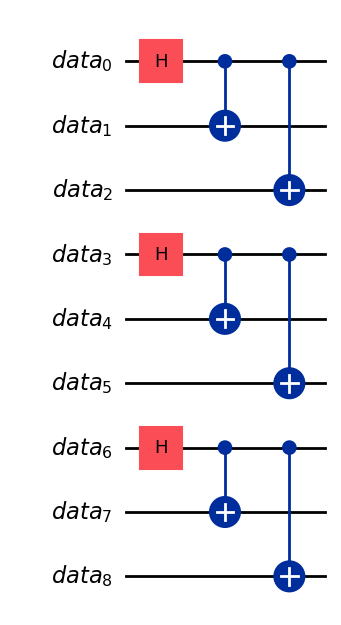

In [2]:
from qiskit import QuantumCircuit, QuantumRegister

def prepare_shor_logical_zero():
    """
    Prepare Shor's 9-qubit logical |0_L> state:
        |0_L> = (|000> + |111>)/sqrt(2)  ⊗  (|000> + |111|)/sqrt(2)  ⊗  (|000> + |111>)/sqrt(2)
    Implementation: for each 3-qubit block, create a GHZ state by H on the
    block's first qubit followed by two CNOTs to the other two in the block.
    """
    data = QuantumRegister(9, 'data')
    qc = QuantumCircuit(data, name="Shor |0_L>")

    # Three 3-qubit blocks: [0,1,2], [3,4,5], [6,7,8]
    blocks = [(0,1,2), (3,4,5), (6,7,8)]

    for a,b,c in blocks:
        qc.h(data[a])          # (|0> + |1>)/√2 on the block's anchor qubit
        qc.cx(data[a], data[b])
        qc.cx(data[a], data[c])  # -> (|000> + |111>)/√2 on that block

    return qc

# Build and draw
logical_zero_circuit = prepare_shor_logical_zero()
logical_zero_circuit.draw('mpl')


## Step2: Implement random X, Z noise model

1. Define the Error Probabilities:

- No error: $1-(a+b)$

- X errors: $a$

- Z errors: $b$

2. Construct the QuantumError:

3. Apply the QuantumError to all single-qubit gates (excluding multi-qubit gates like cx).

In [ ]:
from qiskit_aer.noise import NoiseModel, pauli_error

def make_xz_noise_model(a: float, b: float) -> NoiseModel:
    if a < 0 or b < 0 or a + b > 1:
        raise ValueError("Require a >= 0, b >= 0, and a+b <= 1.")
    single = pauli_error([('X', a), ('Z', b), ('I', 1 - a - b)])
    twoq  = single.tensor(single)  # independent channel on control ⊗ target

    noise = NoiseModel()
    # add to typical 1q native gates (your circuit uses only H and CX; H will be decomposed)
    noise.add_all_qubit_quantum_error(single, ['rz', 'sx', 'x'])
    # add to every CX
    noise.add_all_qubit_quantum_error(twoq, ['cx'])
    return noise

# Example
example_noise_model = make_xz_noise_model(a=0.05, b=0.0)  # pure bit-flip, 5%
print(example_noise_model)

## Stabilizer structure

There are **8 independent stabilizer generators** acting on 9 qubits:

* **Bit-flip (Z-type) checks** inside each 3-qubit block:
$
  Z_1Z_2,; Z_2Z_3;\quad Z_4Z_5,; Z_5Z_6;\quad Z_7Z_8,; Z_8Z_9.
$

* **Phase-flip (X-type) checks** across the 3 blocks:
$
  X_1X_2X_3X_4X_5X_6,\quad X_4X_5X_6X_7X_8X_9.
$

Each stabilizer has eigenvalue (+1) on valid codewords.
Measurement of these operators yields ±1 outcomes corresponding to the parity (like XORs in the repetition code).


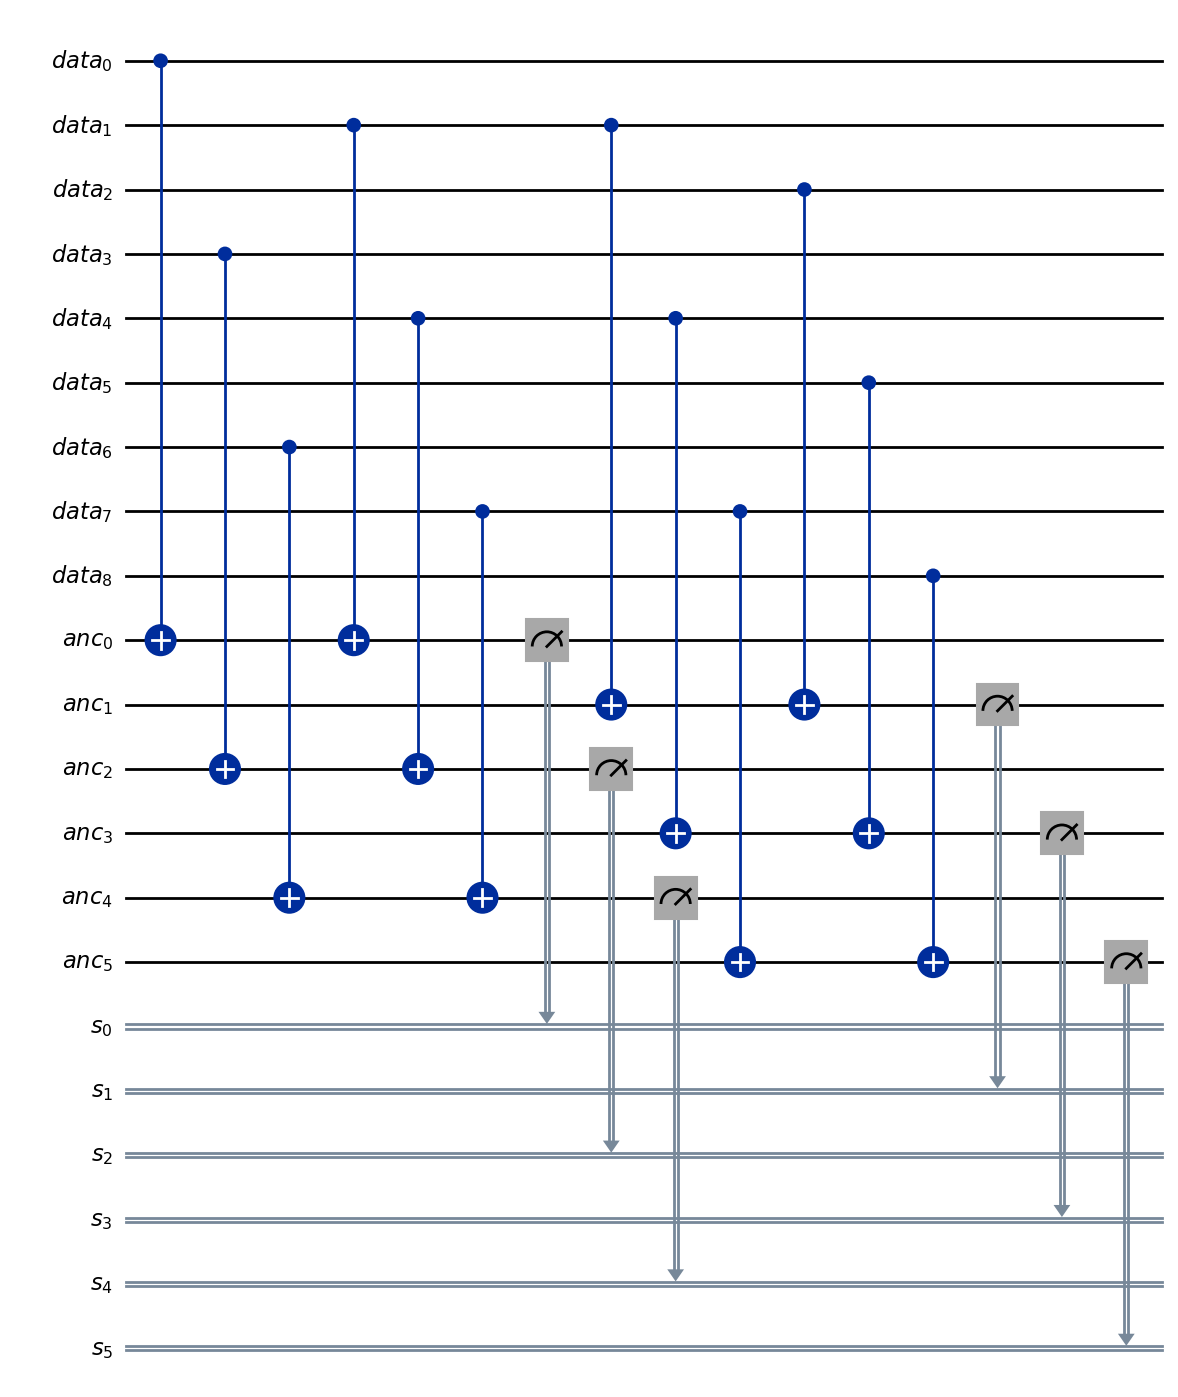

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def shor_syndrome_circuit(mode='X'):
    """
    Shor (9-qubit) code syndrome extraction.

    mode:
      'X'     -> detect X errors by measuring six Z-parities inside blocks:
                 Z1Z2, Z2Z3, Z4Z5, Z5Z6, Z7Z8, Z8Z9   (6 bits)
      'Z'     -> detect Z errors by measuring two X-type stabilizers across blocks:
                 X1..X6,  X4..X9                       (2 bits)
      'both'  -> measure all 8 stabilizers (6 + 2 bits)

    Returns:
      qc   : QuantumCircuit
      data : QuantumRegister (9)
      syn  : ClassicalRegister (num_syndromes = 6|'X', 2|'Z', 8|'both')
    """
    assert mode in {'X', 'Z', 'both'}

    data = QuantumRegister(9, 'data')

    if mode == 'X':
        num_s = 6
    elif mode == 'Z':
        num_s = 2
    else:
        num_s = 8

    # ancillas: one per stabilizer we measure
    anc = QuantumRegister(num_s, 'anc')
    syn = ClassicalRegister(num_s, 's')
    qc = QuantumCircuit(data, anc, syn, name=f"shor_{mode}_syndrome")

    # --- measure X errors (Z-parities inside each 3-qubit block) ---
    # pairs: (1,2), (2,3), (4,5), (5,6), (7,8), (8,9)  [1-based]
    # zero-based indices:
    x_pairs = [(0,1), (1,2), (3,4), (4,5), (6,7), (7,8)]

    if mode in {'X', 'both'}:
        for k, (i, j) in enumerate(x_pairs):
            qc.cx(data[i], anc[k])
            qc.cx(data[j], anc[k])
            qc.measure(anc[k], syn[k])  # record Z_i Z_j parity bit

    # --- measure Z errors (X-type stabilizers across blocks) ---
    # S7 = X1..X6  (qubits 0..5),  S8 = X4..X9  (qubits 3..8)
    if mode in {'Z', 'both'}:
        # choose ancilla indices
        offs = 0 if mode == 'Z' else 6
        # rotate to X-basis so X-parity becomes Z-parity
        for q in range(9):
            qc.h(data[q])

        # first X stabilizer: X1..X6
        a = anc[offs + 0]
        for q in range(0, 6):
            qc.cx(data[q], a)
        qc.measure(a, syn[offs + 0])

        # second X stabilizer: X4..X9
        a = anc[offs + 1]
        for q in range(3, 9):
            qc.cx(data[q], a)
        qc.measure(a, syn[offs + 1])

        # rotate back
        for q in range(9):
            qc.h(data[q])

    return qc, data, syn

# Examples
qcX, dataX, synX = shor_syndrome_circuit('X')      # six bits: Z-pair checks
qcZ, dataZ, synZ = shor_syndrome_circuit('Z')      # two bits: X-block checks
qcB, dataB, synB = shor_syndrome_circuit('both')   # all eight stabilizers

# Draw one of them
qcX.draw('mpl', cregbundle=False, idle_wires=False)
# qcZ.draw('mpl', cregbundle=False, idle_wires=False)
# qcB.draw('mpl', cregbundle=False, idle_wires=False)

## Error correction (Shor’s 9-qubit code)

### We measure two Z-parities **per 3-qubit block**:

* Block A: ( (Z_1Z_2,; Z_2Z_3) \equiv (s^A_0,s^A_1) )
* Block B: ( (Z_4Z_5,; Z_5Z_6) \equiv (s^B_0,s^B_1) )
* Block C: ( (Z_7Z_8,; Z_8Z_9) \equiv (s^C_0,s^C_1) )

For each block, use the **same 3-repetition lookup** (your mapping):

* ((s_0,s_1)=(1,0)) → X on **first** qubit of the block
* ((s_0,s_1)=(1,1)) → X on **second** (middle) qubit
* ((s_0,s_1)=(0,1)) → X on **third** qubit
* ((s_0,s_1)=(0,0)) → no correction

### Correcting Z (phase-flip) errors — use X-type “block parity” syndromes

Now measure the two **X-type** stabilizers across blocks (after H-rotate, measure, H-back):

* (S_{AB}=X_1X_2X_3X_4X_5X_6)  → bit (t_0)
* (S_{BC}=X_4X_5X_6X_7X_8X_9)  → bit (t_1)

For a **single Z error** somewhere in a block, the 2-bit outcome ((t_0,t_1)) tells *which block* flipped:

* ((t_0,t_1)=(1,0)) → Z in **Block A** (qubits 1–3)
* ((t_0,t_1)=(1,1)) → Z in **Block B** (qubits 4–6)
* ((t_0,t_1)=(0,1)) → Z in **Block C** (qubits 7–9)
* ((t_0,t_1)=(0,0)) → no Z error

Any **one** Z in the indicated block will do as a correction (common choice: the block’s anchor).

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def shor_syndrome_circuit_split(mode='X'):
    """
    mode='X'  -> measure Z-parities inside each block:
                 blocks A=(0,1,2), B=(3,4,5), C=(6,7,8).
                 Returns three 2-bit ClassicalRegisters: sA, sB, sC.
                 Bit table per block (same as repetition-3):
                   '00' -> no X in that block
                   '01' -> X on first qubit of the block
                   '11' -> X on middle qubit of the block
                   '10' -> X on last qubit of the block

    mode='Z'  -> measure two X-type stabilizers across blocks:
                 S_AB = X1..X6  (blocks A and B)
                 S_BC = X4..X9  (blocks B and C)
                 Returns one 2-bit ClassicalRegister sZ = [S_AB, S_BC] (LSB/MSB order as coded).
                 Mapping for a single Z error on one block:
                   '10' -> Z in block A
                   '11' -> Z in block B
                   '01' -> Z in block C
                   '00' -> none
    """
    assert mode in {'X', 'Z'}
    data = QuantumRegister(9, 'data')

    if mode == 'X':
        anc = QuantumRegister(6, 'anc')
        sA = ClassicalRegister(2, 'sA')
        sB = ClassicalRegister(2, 'sB')
        sC = ClassicalRegister(2, 'sC')
        qc = QuantumCircuit(data, anc, sA, sB, sC, name='shor_X_syndrome')

        # --- Block A (0,1,2) ---
        qc.cx(data[0], anc[0]); qc.cx(data[1], anc[0]); qc.measure(anc[0], sA[0])  # Z01
        qc.cx(data[1], anc[1]); qc.cx(data[2], anc[1]); qc.measure(anc[1], sA[1])  # Z12

        # --- Block B (3,4,5) ---
        qc.cx(data[3], anc[2]); qc.cx(data[4], anc[2]); qc.measure(anc[2], sB[0])  # Z34
        qc.cx(data[4], anc[3]); qc.cx(data[5], anc[3]); qc.measure(anc[3], sB[1])  # Z45

        # --- Block C (6,7,8) ---
        qc.cx(data[6], anc[4]); qc.cx(data[7], anc[4]); qc.measure(anc[4], sC[0])  # Z67
        qc.cx(data[7], anc[5]); qc.cx(data[8], anc[5]); qc.measure(anc[5], sC[1])  # Z78

        return qc, data, (sA, sB, sC)

    else:  # mode == 'Z'
        anc = QuantumRegister(2, 'anc')
        sZ  = ClassicalRegister(2, 'sZ')
        qc = QuantumCircuit(data, anc, sZ, name='shor_Z_syndrome')

        # rotate to X-basis
        for q in range(9): qc.h(data[q])

        # S_AB = X1..X6  -> use anc[0]
        for q in range(0,6): qc.cx(data[q], anc[0])
        qc.measure(anc[0], sZ[0])

        # S_BC = X4..X9  -> use anc[1]
        for q in range(3,9): qc.cx(data[q], anc[1])
        qc.measure(anc[1], sZ[1])

        # rotate back
        for q in range(9): qc.h(data[q])

        return qc, data, sZ


In [5]:
def apply_shor_recovery_X(qc, data, syn_blocks):
    """
    syn_blocks = (sA, sB, sC), each a 2-bit ClassicalRegister.
    For each block, apply the repetition-3 lookup:
      '01' -> X on first qubit of that block
      '11' -> X on middle qubit
      '10' -> X on last qubit
      '00' -> do nothing
    """
    (sA, sB, sC) = syn_blocks
    blocks = [(0,1,2,sA), (3,4,5,sB), (6,7,8,sC)]
    for (i,j,k,sReg) in blocks:
        with qc.if_test((sReg, int('01',2))): qc.x(data[i])
        with qc.if_test((sReg, int('11',2))): qc.x(data[j])
        with qc.if_test((sReg, int('10',2))): qc.x(data[k])

def apply_shor_recovery_Z(qc, data, sZ):
    """
    sZ is a 2-bit ClassicalRegister with
      bit0 = S_AB (X1..X6), bit1 = S_BC (X4..X9).
    Table for a single Z error:
      '10' -> Z in block A  (apply Z to, e.g., data[0])
      '11' -> Z in block B  (apply Z to, e.g., data[3])
      '01' -> Z in block C  (apply Z to, e.g., data[6])
      '00' -> none
    We choose to correct on the first qubit of the implicated block.
    """
    with qc.if_test((sZ, int('10',2))): qc.z(data[0])  # block A
    with qc.if_test((sZ, int('11',2))): qc.z(data[3])  # block B
    with qc.if_test((sZ, int('01',2))): qc.z(data[6])  # block C


In [ ]:
## Run Experiment

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error


# ----------------------------
# Encoding: Shor |0_L> = (|000>+|111>)/√2 on each 3-qubit block
# ----------------------------
def encode_shor_zero(qc: QuantumCircuit, data: QuantumRegister):
    """
    Prepare Shor's logical |0_L> on 9 data qubits laid out as blocks:
      A: (0,1,2),  B: (3,4,5),  C: (6,7,8)
    Each block becomes a GHZ: (|000> + |111>)/√2.
    """
    for a, b, c in ((0,1,2), (3,4,5), (6,7,8)):
        qc.h(data[a])
        qc.cx(data[a], data[b])
        qc.cx(data[a], data[c])


# ----------------------------
# Build experiment (X- or Z- correction)
# ----------------------------
def build_shor_experiment(error_type='X', flip_qubit=None, measure_name='out'):
    """
    Build a full Shor experiment:
      encode |0_L>  -> (optional X/Z on one data qubit)
      -> measure appropriate stabilizers (syndrome)
      -> conditional recovery
      -> final data measurement.

    error_type:
      'X' : correct bit flips (measure six Z-parities inside blocks)
      'Z' : correct phase flips (measure two X-parities across blocks)
    flip_qubit: None or 0..8 to inject a single X/Z error before syndrome.
    """
    error_type = error_type.upper()
    assert error_type in {'X', 'Z'}

    data = QuantumRegister(9, 'data')

    if error_type == 'X':
        # 6 syndromes: Z01,Z12,Z34,Z45,Z67,Z78 (two per block)
        anc = QuantumRegister(6, 'anc')
        syn = ClassicalRegister(6, 's')
    else:
        # 2 syndromes: SAB = X1..X6 , SBC = X4..X9
        anc = QuantumRegister(2, 'anc')
        syn = ClassicalRegister(2, 's')

    out = ClassicalRegister(9, measure_name)
    qc = QuantumCircuit(data, anc, syn, out, name=f"shor_{error_type}")

    # Encode |0_L>
    encode_shor_zero(qc, data)
    qc.barrier()

    # Optional single-qubit error injection
    if flip_qubit is not None:
        (qc.x if error_type == 'X' else qc.z)(data[flip_qubit])
    qc.barrier()

    # ----- Syndrome extraction -----
    if error_type == 'X':
        # measure Z-parities within each block; map onto anc[0..5]
        pairs = [(0,1), (1,2), (3,4), (4,5), (6,7), (7,8)]
        for k, (i, j) in enumerate(pairs):
            qc.cx(data[i], anc[k])
            qc.cx(data[j], anc[k])
            qc.measure(anc[k], syn[k])  # record Z_i Z_j

        # ----- Conditional recovery (repetition-3 per block) -----
        # For each block, 2-bit syndrome → which physical qubit to flip:
        # '00' = none, '01' = first, '11' = middle, '10' = last
        # Block A (anc 0,1):
        with qc.if_test((syn, 0b000001)): qc.x(data[0])  # A: '01'
        with qc.if_test((syn, 0b000011)): qc.x(data[1])  # A: '11'
        with qc.if_test((syn, 0b000010)): qc.x(data[2])  # A: '10'
        # Block B (anc 2,3) -> their bits occupy positions 2,3 in syn
        with qc.if_test((syn, 0b000101)): qc.x(data[3])  # B: '01'
        with qc.if_test((syn, 0b000111)): qc.x(data[4])  # B: '11'
        with qc.if_test((syn, 0b000110)): qc.x(data[5])  # B: '10'
        # Block C (anc 4,5)
        with qc.if_test((syn, 0b010001)): qc.x(data[6])  # C: '01'
        with qc.if_test((syn, 0b010011)): qc.x(data[7])  # C: '11'
        with qc.if_test((syn, 0b010010)): qc.x(data[8])  # C: '10'

    else:  # error_type == 'Z'
        # Rotate to X basis so X-parity becomes Z-parity on ancillas
        for q in range(9): qc.h(data[q])

        # SAB = X1..X6 (data 0..5)  → anc[0]
        for q in range(0, 6): qc.cx(data[q], anc[0])
        qc.measure(anc[0], syn[0])

        # SBC = X4..X9 (data 3..8)  → anc[1]
        for q in range(3, 9): qc.cx(data[q], anc[1])
        qc.measure(anc[1], syn[1])

        # Rotate back
        for q in range(9): qc.h(data[q])

        # ----- Conditional Z recovery (identify which block) -----
        # Table for a single Z error (SAB,SBC):
        #   '10' -> block A ; '11' -> block B ; '01' -> block C ; '00' -> none
        with qc.if_test((syn, 0b10)): qc.z(data[0])  # correct in block A (choose anchor)
        with qc.if_test((syn, 0b11)): qc.z(data[3])  # block B
        with qc.if_test((syn, 0b01)): qc.z(data[6])  # block C

    qc.barrier()
    # Final data measurement (for verification / logical success stats)
    qc.measure(data, out)
    return qc


# ----------------------------
# Noise model (same as your rep3 helper)
# ----------------------------
def make_xz_noise_model(a: float, b: float) -> NoiseModel:
    if a < 0 or b < 0 or a + b > 1:
        raise ValueError("Require a >= 0, b >= 0, and a+b <= 1.")
    single = pauli_error([('X', a), ('Z', b), ('I', 1 - a - b)])
    twoq  = single.tensor(single)
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(single, ['rz', 'sx', 'x', 'h', 'id'])
    nm.add_all_qubit_quantum_error(twoq, ['cx'])
    return nm


# ----------------------------
# Runner
# ----------------------------
def run_counts(qc, noise_model=None, shots=4000):
    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, backend=sim)
    res = sim.run(tqc, shots=shots).result()
    return res.get_counts(tqc)


# ----------------------------
# Logical success metric for Shor |0_L>
# (majority vote per block on Z-basis data bits)
# ----------------------------
def shor_logical_success_from_counts(counts: dict) -> float:
    """
    Treat the left group of bits in each key as the 9 data measurements.
    Success if each 3-qubit block has majority '0' (i.e., patterns in {000,001,010,100}).
    """
    total = sum(counts.values())
    success = 0
    for key, v in counts.items():
        data_bits = key.split()[0]        # 'ddd...ddd ssss...' -> take 9-bit data
        blocks = (data_bits[0:3], data_bits[3:6], data_bits[6:9])
        ok = all(block.count('1') <= 1 for block in blocks)  # majority 0 in each block
        if ok:
            success += v
    return success / total if total else 0.0


In [7]:
# 1) Deterministic X-error correction (inject X on qubit 4 in middle block)
qc = build_shor_experiment(error_type='X', flip_qubit=4)
print(run_counts(qc, noise_model=None, shots=2000))

# 2) Probabilistic X-noise across the circuit (3% per gate)
nm = make_xz_noise_model(a=0.03, b=0.0)
qc = build_shor_experiment(error_type='X', flip_qubit=None)
counts = run_counts(qc, noise_model=nm, shots=20000)
print("logical success (X-mode) ≈", shor_logical_success_from_counts(counts))

# 3) Probabilistic Z-noise with Z-correction
nm = make_xz_noise_model(a=0.0, b=0.03)
qc = build_shor_experiment(error_type='Z', flip_qubit=None)
counts = run_counts(qc, noise_model=nm, shots=20000)
# For Z-only noise, Z-correction success is best checked by the two X-syndromes == '00':
z_syndrome_ok = sum(v for k, v in counts.items() if k.split()[-1] == '00') / sum(counts.values())
print("post-recovery X-syndromes == 00 fraction (Z-mode) ≈", z_syndrome_ok)


{'111010111 001100': 258, '111010000 001100': 226, '000010000 001100': 267, '000101000 001100': 246, '111101111 001100': 243, '000010111 001100': 240, '000101111 001100': 250, '111101000 001100': 270}
logical success (X-mode) ≈ 0.1289
post-recovery X-syndromes == 00 fraction (Z-mode) ≈ 0.65205
